# Neural Network Library - Project Demo

CSE473s: Computational Intelligence - Fall 2025

## Overview

This notebook demonstrates a complete neural network library built from scratch using only NumPy.


## Setup and Imports

First, we'll import the necessary libraries and our custom neural network implementation.

In [54]:
# Import required libraries
import numpy as np
import sys
import time
import tensorflow as tf
from tensorflow import keras

# Add library to path
sys.path.insert(0, '../')

# Import our neural network library
from lib import Network, Dense, ReLU, Sigmoid, Tanh, Softmax, MSE, SGD, plot_losses, plot_decision_boundary, SVM, accuracy_score, confusion_matrix, classification_report

## Part 1: XOR Problem Setup

We'll start with the classic XOR dataset, which is a simple binary classification problem that requires a non-linear decision boundary. The inputs are bipolar (-1 or 1) and the target outputs follow the XOR logic.

In [9]:
# XOR dataset
X = np.array([
    [-1,-1],
    [-1,1],
    [1,-1],
    [1,1]
], dtype=float)

y = np.array([
    [-1],
    [1],
    [1],
    [-1]
], dtype=float)

### Training the Custom Neural Network

Now we'll build and train our custom neural network. The architecture consists of:
- Input layer: 2 neurons (for 2D inputs)
- Hidden layer: 4 neurons with Tanh activation
- Output layer: 1 neuron with Tanh activation

We'll use Mean Squared Error (MSE) loss and Stochastic Gradient Descent (SGD) optimizer with a learning rate of 0.5.

Epoch 0, Loss: 1.000217
Epoch 500, Loss: 0.001780
Epoch 1000, Loss: 0.000507
Epoch 1500, Loss: 0.000292
Epoch 2000, Loss: 0.000204
Epoch 2500, Loss: 0.000156
Epoch 3000, Loss: 0.000127
Epoch 3500, Loss: 0.000106
Epoch 4000, Loss: 0.000092
Epoch 4500, Loss: 0.000080
Custom NN training time: 0.3920 seconds

Network Architecture:
Layer 0: Dense | Weights: (2, 4) | Biases: (1, 4)
Layer 1: Tanh
Layer 2: Dense | Weights: (4, 1) | Biases: (1, 1)
Layer 3: Tanh

Final model predictions:
Input (x1,x2)        Target     Predicted    Error     
------------------------------------------------------------
(-1.0, -1.0)         -1.0000    -0.9906      0.0094  ✓
(-1.0, 1.0)          +1.0000    +0.9932      0.0068  ✓
(1.0, -1.0)          +1.0000    +0.9932      0.0068  ✓
(1.0, 1.0)           -1.0000    -0.9898      0.0102  ✓
------------------------------------------------------------


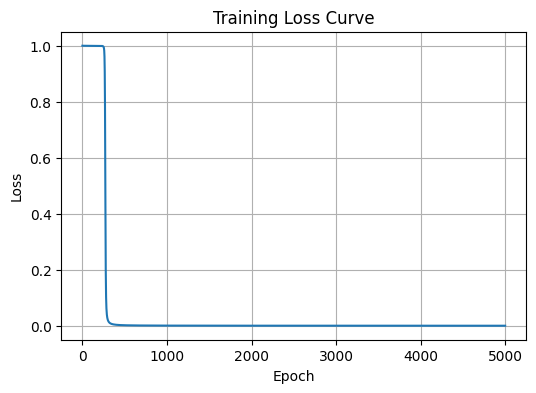


VISUALIZATION: Binary Decision Boundary


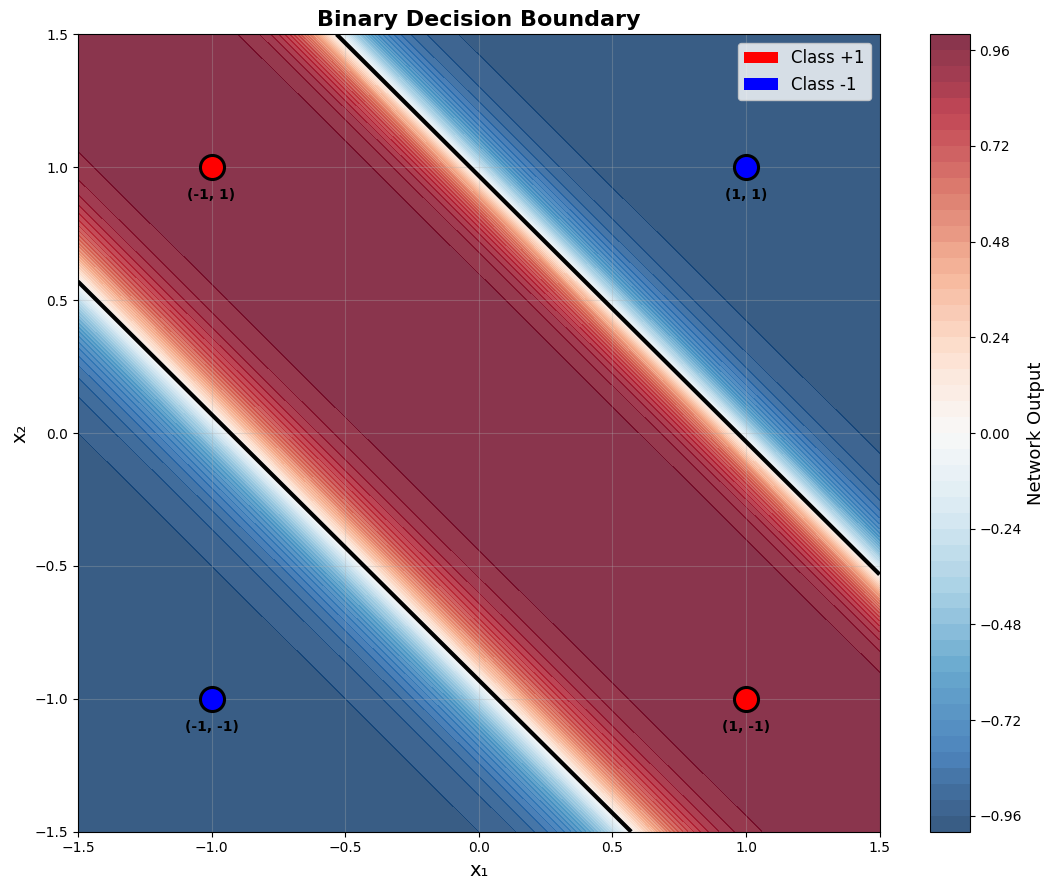

Binary decision boundary visualization complete!


In [10]:
model = Network([
    Dense(2, 4),
    Tanh(),
    Dense(4, 1),
    Tanh()
])

loss_fn = MSE()
optimizer = SGD(learning_rate=0.5)

start_custom = time.time()
model.train(X, y, loss_fn, optimizer, epochs=5000, verbose=True)
custom_time = time.time() - start_custom
print(f"Custom NN training time: {custom_time:.4f} seconds")

model.summary()
model.print_final_predictions(X, y)

plot_losses(model.loss_history)
plot_decision_boundary(model, X, y)

## Part 2: Gradient Checking

We implement a gradient checking function to validate that our backpropagation implementation is correct. This uses numerical differentiation (finite differences) to compare against our analytical gradients for all weight and bias parameters in Dense layers.

In [11]:
def gradient_check(model, X, y, loss_fn, epsilon=1e-5, tol=1e-7):
    """
    Performs gradient checking for all Dense layers in the model.
    
    Arguments:
        model    : Network object
        X, y     : Input and target output
        loss_fn  : Loss class (e.g., MSE)
        epsilon  : Small value for numerical gradient
        tol      : Tolerance for max difference
    """
    
    # 1. Forward and backward pass to compute analytical gradients
    y_pred = model.forward(X)
    grad_output = loss_fn.grad(y_pred, y)
    model.backward(grad_output)
    
    for idx, layer in enumerate(model.layers):
        if hasattr(layer, 'W'):
            print(f"\n--- Layer {idx} ---")
            
            # ----- Gradient for weights -----
            num_grad_W = np.zeros_like(layer.W)
            for i in range(layer.W.shape[0]):
                for j in range(layer.W.shape[1]):
                    old_val = layer.W[i,j]
                    
                    layer.W[i,j] = old_val + epsilon
                    loss_plus = loss_fn.loss(model.forward(X), y)
                    
                    layer.W[i,j] = old_val - epsilon
                    loss_minus = loss_fn.loss(model.forward(X), y)
                    
                    num_grad_W[i,j] = (loss_plus - loss_minus) / (2*epsilon)
                    layer.W[i,j] = old_val  # reset
            
            max_diff_W = np.max(np.abs(num_grad_W - layer.dW))
            print(f"Max difference in W: {max_diff_W}")
            
            # ----- Gradient for biases -----
            num_grad_b = np.zeros_like(layer.b)
            for i in range(layer.b.shape[1]):
                old_val = layer.b[0,i]
                
                layer.b[0,i] = old_val + epsilon
                loss_plus = loss_fn.loss(model.forward(X), y)
                
                layer.b[0,i] = old_val - epsilon
                loss_minus = loss_fn.loss(model.forward(X), y)
                
                num_grad_b[0,i] = (loss_plus - loss_minus) / (2*epsilon)
                layer.b[0,i] = old_val  # reset
            
            max_diff_b = np.max(np.abs(num_grad_b - layer.db))
            print(f"Max difference in b: {max_diff_b}")
            
            if max_diff_W < tol and max_diff_b < tol:
                print("Gradients match within tolerance.")
            else:
                print("Warning: Gradients may be incorrect.")

gradient_check(model, X, y, loss_fn)



--- Layer 0 ---
Max difference in W: 1.8699099343585934e-14
Max difference in b: 3.1080305294478236e-14
Gradients match within tolerance.

--- Layer 2 ---
Max difference in W: 4.373960232634949e-14
Max difference in b: 6.275646777416377e-15
Gradients match within tolerance.


## Part 3: Comparing results with TensorFlow

In [12]:
# --- 1. Custom model training ---
y_pred = model.forward(X)
final_custom_loss = loss_fn.loss(y_pred, y)

# --- 2. TensorFlow model training ---
tf_model = keras.Sequential([
    keras.Input(shape=(2,)),       
    keras.layers.Dense(4, activation='tanh'),
    keras.layers.Dense(1, activation='tanh')
])
tf_model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.5),
                 loss='mean_squared_error')

start_tf = time.time()
tf_model.fit(X, y, epochs=5000, verbose=0)
tf_time = time.time() - start_tf

y_tf_pred = tf_model.predict(X)
final_tf_loss = tf_model.evaluate(X, y, verbose=0)

# --- 3. Compare predictions ---
diff = np.abs(y_pred - y_tf_pred)
max_diff = np.max(diff)

# --- 4. Print results ---
print("\nCustom model predictions:")
for i in range(len(X)):
    print(f"Input: {X[i]}, Predicted: {y_pred[i][0]:.4f}, True: {y[i][0]}")

print("\nTensorFlow model predictions:")
for i in range(len(X)):
    print(f"Input: {X[i]}, Predicted: {y_tf_pred[i][0]:.4f}, True: {y[i][0]}")

print(f"\nMax difference between custom model and TensorFlow predictions: {max_diff:.6f}")
print(f"Custom model training time: {custom_time:.4f} sec")
print(f"TensorFlow training time: {tf_time:.4f} sec")
print(f"Final custom model loss: {final_custom_loss:.6f}")
print(f"Final TensorFlow model loss: {final_tf_loss:.6f}")

# --- 5. Plot decision boundary for TensorFlow model ---
plot_decision_boundary(lambda x: tf_model(x).numpy(), X, y)

KeyboardInterrupt: 

### **Model Comparison**

| Aspect                | Custom Model       | TensorFlow Model       |
|-----------------------|-----------------|----------------------|
| **Training Time**      | Less | Much more    |
| **Ease of Implementation** | Harder        | Easier            |
| **Flexibility**        | High           | Medium             |
| **Debuggability**      | Easier        | Slightly complex   |
| **Integration**        | Manual         | Built-in functions|


---

### **General Conclusions**

1. **Custom model:**  
   - Full control over architecture and training.  
   - Easier to debug and understand learning behavior.  
   - Requires more manual coding and careful tuning.  

2. **TensorFlow model:**  
   - Fast to implement for standard tasks.  
   - Optimized performance with built-in layers and GPU support.  
   - Less internal control, but easier to scale.

---

### **Effect of Changing Parameters**

| Parameter       | Effect on Model Behavior                                           |
|-----------------|------------------------------------------------------------------|
| **Learning Rate** | Higher → faster convergence but risk of overshooting; Lower → slower but stable |
| **Epochs**        | More → better convergence but may overfit; Fewer → faster but undertrained |
| **Activation Functions** | `tanh` smooths, `relu` faster training, `sigmoid` saturates easily |
| **Hidden Units / Layers** | More → captures complex patterns but risk overfitting; Fewer → simpler and faster |

**Summary:**  

- **Custom model**: Great for learning and experimentation.  
- **TensorFlow model**: Ideal for rapid prototyping and scaling.  
- Hyperparameters (learning rate, epochs, architecture) directly affect convergence and performance.

## Milestone 2: Autoencoder on MNIST

In this section, we will train an **Autoencoder** to compress handwritten digits (MNIST dataset) into a lower-dimensional latent space and then reconstruct them.

**Architecture:**
* **Input:** 784 features (flattened 28x28 images)
* **Encoder:** Compress to 32 latent features (ReLU activation)
* **Decoder:** Reconstruct to 784 features (Sigmoid activation)

In [33]:
# --- Step 1: Data Loading ---
(x_train_raw, y_train), (x_test_raw, y_test) = tf.keras.datasets.mnist.load_data()

# 2. Preprocessing
# Flatten images: (N, 28, 28) -> (N, 784)
X_train = x_train_raw.reshape(x_train_raw.shape[0], -1)
X_test = x_test_raw.reshape(x_test_raw.shape[0], -1)

# Normalize to [0, 1] range (required for Sigmoid output match)
X_train = X_train / 255.0
X_test = X_test / 255.0

# .astype('float32')

# 3. Subsampling for quicker demo
N_SAMPLES = 2000 
N_TEST = 500

X_train_small = X_train[:N_SAMPLES]
y_train_small = y_train[:N_SAMPLES]
X_test_small = X_test[:N_TEST]
y_test_small = y_test[:N_TEST]

print(f"Training Data Shape: {X_train_small.shape}")
print(f"Testing Data Shape: {X_test_small.shape}")

Training Data Shape: (2000, 784)
Testing Data Shape: (500, 784)


### Training the Autoencoder

We define the network using our custom `Network` class. Note that for an autoencoder, the target labels `y` are the same as the input data `X`.

Starting Autoencoder Training...
Epoch 0, Loss: 0.255095
Epoch 500, Loss: 0.039234
Epoch 1000, Loss: 0.019393
Epoch 1500, Loss: 0.013185
Training finished in 413.20 seconds (6.89 minute).


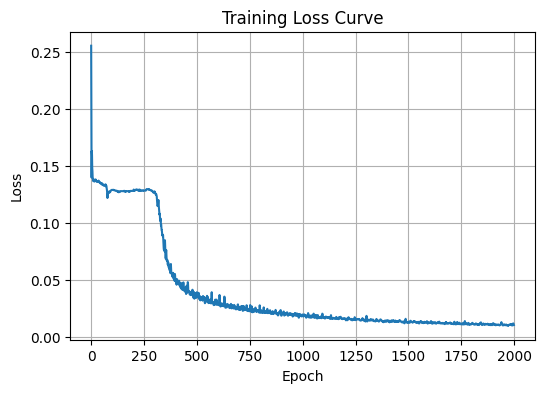

In [34]:
# 1. Define Architecture
input_dim = 784   # 28x28 pixels
latent_dim = 64   # Bottleneck layer size

layers = [
    # Encoder
    Dense(input_dim, 256),
    ReLU(),
    Dense(256, latent_dim),
    ReLU(),
    # Decoder
    Dense(latent_dim, 256),
    ReLU(),
    Dense(256, input_dim),
    Sigmoid()  
]

# 2. Initialize Network, Loss, and Optimizer
autoencoder = Network(layers)
loss_fn = MSE()
optimizer = SGD(learning_rate=0.1) 

# 3. Train the Network
print("Starting Autoencoder Training...")
start_time = time.time()

# Note: the target 'y' is the same as input 'X'
autoencoder.train(
    X_train_small, 
    X_train_small,  
    loss_fn, 
    optimizer, 
    epochs=2000
)

print(f"Training finished in {time.time() - start_time:.2f} seconds ({(time.time() - start_time)/60:.2f} minute).")

# 4. Visualize Training Loss
plot_losses(autoencoder.loss_history)

### Reconstruction Results

We visualize how well the network reconstructs unseen test images. The top row shows the original digits, and the bottom row shows the output from our custom autoencoder.

Reconstruction results on Test Data:


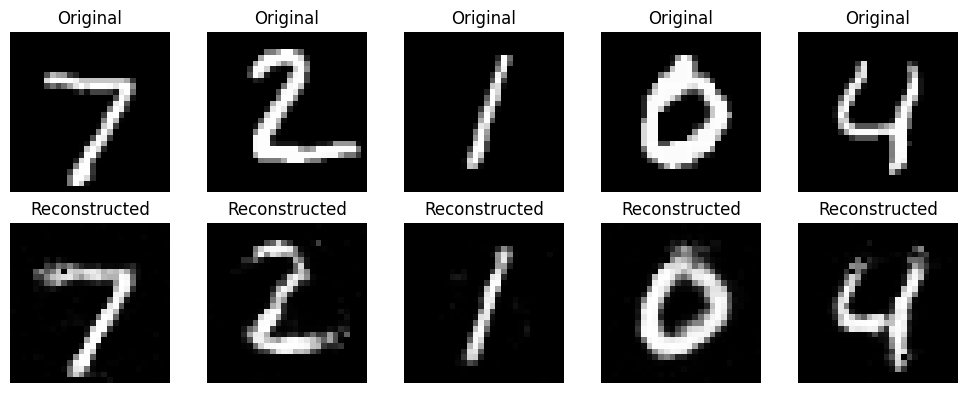

In [35]:
import matplotlib.pyplot as plt
def visualize_reconstruction(model, X_original, n_samples=5):
    # Get model predictions (reconstructions)
    reconstructed = model.forward(X_original[:n_samples])
    
    plt.figure(figsize=(10, 4))
    for i in range(n_samples):
        # Plot Original
        ax = plt.subplot(2, n_samples, i + 1)
        plt.imshow(X_original[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis("off")
        
        # Plot Reconstructed
        ax = plt.subplot(2, n_samples, i + 1 + n_samples)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.title("Reconstructed")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

print("Reconstruction results on Test Data:")
visualize_reconstruction(autoencoder, X_test_small)

## Part 3: Latent Space Classification

Here we demonstrate **Transfer Learning**. We extract the encoder (the first half of the network) to generate compressed 64-dimensional features. We then train a standard SVM classifier on these features to classify the digits.

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# 1. Extract the Encoder
encoder = Network(autoencoder.layers[:4])

print("Extracting features...")
# Generate latent representations (64-dim vectors) for training and test sets
latent_train = encoder.forward(X_train_small)
latent_test = encoder.forward(X_test_small)

print(f"Latent Representation Shape: {latent_train.shape}")

Extracting features...
Latent Representation Shape: (2000, 64)


SVM Accuracy: 84.80%

Classification Report:
Class 0: precision=0.89, recall=0.93, f1-score=0.91, support=42
Class 1: precision=0.99, recall=1.00, f1-score=0.99, support=67
Class 2: precision=0.85, recall=0.84, f1-score=0.84, support=55
Class 3: precision=0.80, recall=0.78, f1-score=0.79, support=45
Class 4: precision=0.85, recall=0.85, f1-score=0.85, support=55
Class 5: precision=0.81, recall=0.70, f1-score=0.75, support=50
Class 6: precision=0.93, recall=0.88, f1-score=0.90, support=43
Class 7: precision=0.78, recall=0.86, f1-score=0.82, support=49
Class 8: precision=0.78, recall=0.78, f1-score=0.78, support=40
Class 9: precision=0.77, recall=0.81, f1-score=0.79, support=54

Confusion Matrix:
[[39  0  0  0  0  0  0  1  2  0]
 [ 0 67  0  0  0  0  0  0  0  0]
 [ 1  0 46  2  0  0  0  4  2  0]
 [ 0  0  2 35  1  4  1  2  0  0]
 [ 0  1  2  0 47  0  1  0  0  4]
 [ 1  0  1  3  2 35  1  2  3  2]
 [ 2  0  1  0  1  0 38  0  1  0]
 [ 0  0  0  1  0  0  0 42  0  6]
 [ 1  0  1  1  1  3  0  1 31  1]

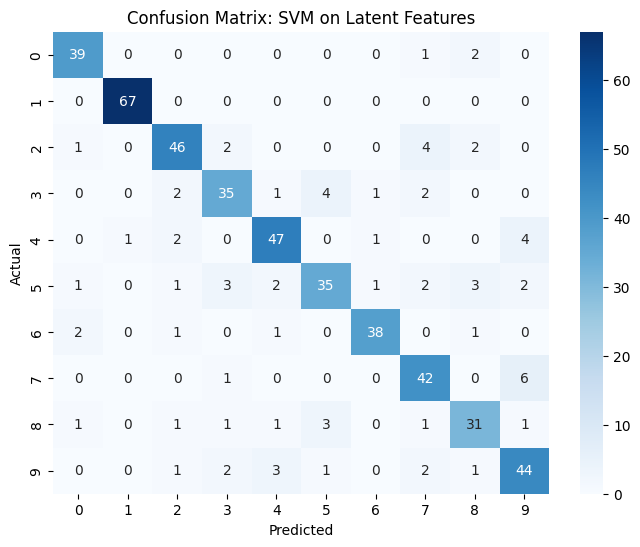

In [ ]:
# Train SVM on latent features
svm = SVM(learning_rate=0.0001, lambda_param=0.01, num_epochs=1000, num_classes=10)
svm.fit(latent_train, y_train_small)

# Predictions
y_pred = svm.predict(latent_test)

# Metrics
acc = accuracy_score(y_test_small, y_pred)
print(f"SVM Accuracy: {acc*100:.2f}%")

print("\nClassification Report:")
report = classification_report(y_test_small, y_pred)
for cls, stats in report.items():
    print(f"Class {cls}: precision={stats['precision']:.2f}, recall={stats['recall']:.2f}, f1-score={stats['f1-score']:.2f}, support={stats['support']}")

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test_small, y_pred)
print(cm)

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test_small, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: SVM on Latent Features')
plt.show()


## Part 4: TensorFlow & Keras Comparison

In this final section, we implement the **exact same autoencoder architecture** using TensorFlow/Keras. This serves as a benchmark to validate our custom library's:
1.  **Correctness:** Do both models converge to a similar loss?
2.  **Performance:** How much faster is the optimized C++ backend of TensorFlow?

In [50]:
# --- Section 5: TensorFlow Comparison ---
from tensorflow import keras 
from tensorflow.keras import layers, models, optimizers 

print(f"TensorFlow Version: {tf.__version__}")

# 1. Define the 4-layer autoencoder matching your custom library
tf_model = models.Sequential([
    layers.InputLayer(input_shape=(784,)),
    layers.Dense(256, activation='relu'),  # Encoder Layer 1
    layers.Dense(64, activation='relu'),   # Encoder Layer 2 (latent space)
    layers.Dense(256, activation='relu'),  # Decoder Layer 1
    layers.Dense(784, activation='sigmoid') # Decoder Layer 2 (output)
])

# 2. Compile with same optimizer and loss
sgd = optimizers.SGD(learning_rate=0.1)  
tf_model.compile(optimizer=sgd, loss='mse')

# 3. Train and measure time
print("Training TensorFlow Model...")
start_time_tf = time.time()

history = tf_model.fit(
    X_train_small, 
    X_train_small, 
    epochs=2000,          
    batch_size=32,       
    verbose=1
)

tf_duration = time.time() - start_time_tf
tf_final_loss = history.history['loss'][-1]

print(f"TF Training finished in {tf_duration:.2f} seconds ({tf_duration/60:.2f} minutes).")
print(f"TF Final Loss: {tf_final_loss:.6f}")

TensorFlow Version: 2.20.0
Training TensorFlow Model...
Epoch 1/2000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2315 
Epoch 2/2000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2303
Epoch 3/2000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2289
Epoch 4/2000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2270
Epoch 5/2000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2241
Epoch 6/2000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2186
Epoch 7/2000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2077
Epoch 8/2000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1851
Epoch 9/2000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1466
Epoch 10/2000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1067
Epoch 11/2000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0848
Epoch 12/2000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0765
Epoch 13/2000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0734
Epoch 14/2000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0720


### Comparison Results

We compare the reconstruction quality visually and the training metrics numerically.

Visual Comparison of Reconstructions:


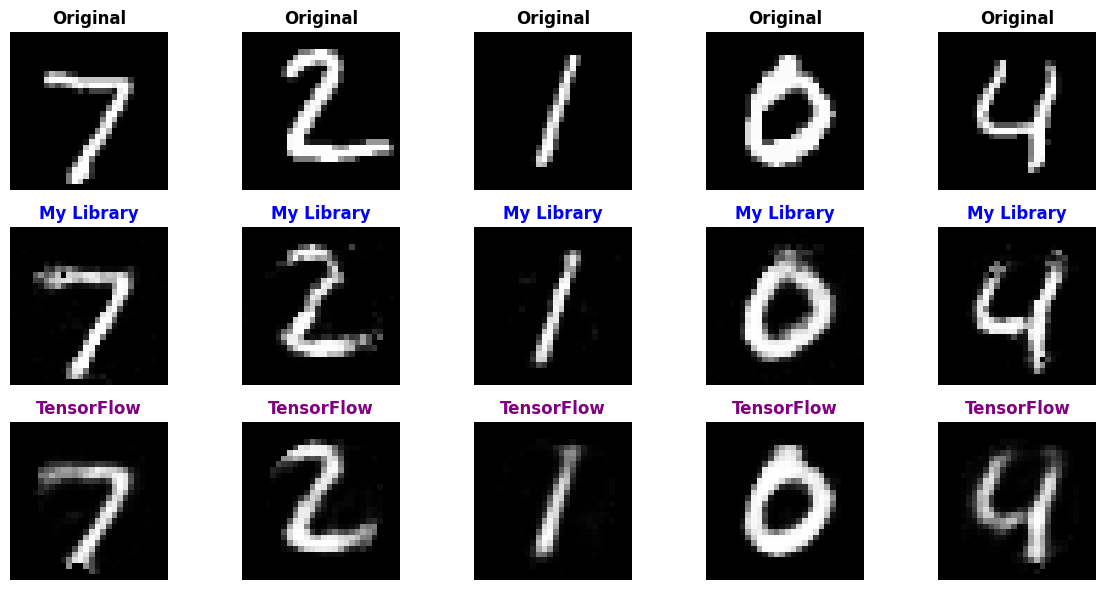

In [ ]:
def compare_reconstructions(custom_model, tf_model, X, n=5):
    # Get predictions
    custom_preds = custom_model.forward(X[:n])
    tf_preds = tf_model.predict(X[:n], verbose=0)
    
    plt.figure(figsize=(12, 6))
    for i in range(n):
        # 1. Original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.title("Original", fontsize=12)
        plt.axis("off")
        
        # 2. Our Library
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(custom_preds[i].reshape(28, 28), cmap='gray')
        plt.title("My Library", fontsize=12, color='blue')
        plt.axis("off")

        # 3. TensorFlow
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(tf_preds[i].reshape(28, 28), cmap='gray')
        plt.title("TensorFlow", fontsize=12, color='purple')
        plt.axis("off")
        
    plt.tight_layout()
    plt.show()

print("Visual Comparison of Reconstructions:")
compare_reconstructions(autoencoder, tf_model, X_test_small)

In [52]:
# --- Metrics Comparison Table ---
import pandas as pd

# 1. Retrieve Data
# Get the final loss from your custom autoencoder's history
custom_loss = autoencoder.loss_history[-1]

# 2. Create the Data Dictionary
data = {
    "Metric": ["Final Loss (MSE)", "Training Time (seconds)"],
    "lib": [f"{custom_loss:.6f}", f"{time.time() - start_time:.2f}"], 
    "TensorFlow / Keras": [f"{tf_final_loss:.6f}", f"{tf_duration:.2f}"]
}

# 3. Create a DataFrame
df = pd.DataFrame(data)

# 4. Display as a styled table
print("\n" + "="*20 + " FINAL BENCHMARK RESULTS " + "="*20)
display(df.style.hide(axis='index'))

# 5. Print formatted Markdown for your PDF report
# print("\n[Copy-Paste for Report] Markdown Format:")
# markdown_table = df.to_markdown(index=False)
# print(markdown_table)


==================== FINAL BENCHMARK RESULTS ====================


Metric,lib,TensorFlow / Keras
Final Loss (MSE),0.010534,0.012621
Training Time (seconds),2633.45,464.36
